# Separability of legal documents according to precedent citations

- Lucas Emanuel Resck Domingues
- Machine Learning assignment
- Professor Rodrigo Targino, FGV-EMAp

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dataset</a></span><ul class="toc-item"><li><span><a href="#Binding-Precedents" data-toc-modified-id="Binding-Precedents-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Binding Precedents</a></span></li><li><span><a href="#Dataset-description" data-toc-modified-id="Dataset-description-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Dataset description</a></span></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li></ul></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Methodology</a></span><ul class="toc-item"><li><span><a href="#Dataset-split" data-toc-modified-id="Dataset-split-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Dataset split</a></span></li><li><span><a href="#Text-preprocessing" data-toc-modified-id="Text-preprocessing-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Text preprocessing</a></span></li><li><span><a href="#Document-embeddings" data-toc-modified-id="Document-embeddings-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Document embeddings</a></span></li><li><span><a href="#Machine-learning-models" data-toc-modified-id="Machine-learning-models-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Machine learning models</a></span></li><li><span><a href="#Performance-metrics" data-toc-modified-id="Performance-metrics-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Performance metrics</a></span></li></ul></li><li><span><a href="#Results-and-discussion" data-toc-modified-id="Results-and-discussion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Results and discussion</a></span><ul class="toc-item"><li><span><a href="#Dataset-split-and-text-preprocessing" data-toc-modified-id="Dataset-split-and-text-preprocessing-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Dataset split and text preprocessing</a></span></li><li><span><a href="#Text-preprocessing" data-toc-modified-id="Text-preprocessing-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Text preprocessing</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

## Setup

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

sns.set()

In [2]:
data_path = os.path.join('../data/docs')

## Introduction

The Brazilian Supreme Court (STF) is the highest law court in Brazil. It produces a huge number of documents during its functioning, \textit{e.g.}, there were produced more than 1 million STF decisions between 2011 and 2020 \cite{}. STF is not the only institution that deals with overload: it is spread all over the Brazilian Judicial System.

One approach to solve this problem is the so-called precedent: when a similar case has to be decided again, this new decision can be taken based on the referenced old decision. This way, cases are solved faster. Many precedents about a subject in a court are consolidated in what is called a ``súmula'', a document that resumes the court understanding about that subject. However, the application of this understanding is not mandatory, and the judge can take a different decision. This situation can lead not only to judicial inefficiency, but also to judicial insecurity: similar cases with different results.

With this situation in mind, STF was allowed, in 2004, by Constitutional Amendment, to create "Súmulas Vinculantes", which we will call here "Binding Precedents", or just BPs. They are basically the old súmulas, but with mandatory application. These BPs are frequently cited in the STF decisions.

It seems trivial that documents that cite the same precedents have the same subjects, and documents that cite different precedents have different subjects, in general. However, can machine learning models and algorithms identify this pattern themselves? That is, if a trained machine learning model is presented to a document, can it predict which precedent is being cited? These questions are very relevant because, if the answer is yes, artificial intelligence algorithms can be very helpful in assisting legal experts during their analysis, considering the big number of long legal documents.

This situation of predicting the correct precedent is what is being called here as ``separability'' of documents. In this assignment, this separability will consider Binding Precedents in STF decisions. This work is organized as follows.

## Dataset

### Binding Precedents

Until June 2021, 58 Binding Precendents have already been created. For example, take a look at BP 10's text:

\textit{``Viola a cláusula de reserva de plenário (CF, artigo 97) a decisão de órgão fracionário de tribunal que, embora não declare expressamente a inconstitucionalidade de lei ou ato normativo do Poder Público, afasta sua incidência, no todo ou em parte.''}

Although it can lead to some insights, we are not interested in studying the meaning of all the BPs.

### Dataset description

The dataset used thoughout this work is composed by decisions generated by STF that cite at least one Binding Precedent. Although these documents are public, they are very difficult to be accessed, mainly when it is necessary a big amount of data. This way, we use a dataset gathered in the context of Supremo em Números project \cite{}, from FGV's Law School.

The dataset, in the way we have it, is composed by 58 CSV files of structured data, with columns:
- title: document title, formed by date, document type and an ID;
- raw_text: document's raw text;
- i_cite: list of cited precedents, including BPs, already extracted from the raw texts;
- date: document's publication date.

See a sample:

In [3]:
pd.read_csv(os.path.join(data_path, 'docs_sv_10.csv')).sample()

,title,raw_text,i_cite,date
14980,20161109_Rcl_25539_310673321,MEDIDA CAUTELAR NA RECLAMAÇÃO 25.539 SANTA CAT...,"['sum. 339 N/A N/A N/A 11639 403', 'rcl 23712 ...",2016-11-09


In [4]:
print(pd.read_csv(os.path.join(data_path, 'docs_sv_10.csv')).sample().to_latex())

\begin{tabular}{lllll}
\toprule
{} &                         title &                                           raw\_text &                                    i\_cite &        date \\
\midrule
602 &  20170517\_RE\_948741\_311807724 &  RECURSO EXTRAORDINÁRIO 948.741 SANTA CATARINA\textbackslash ... &  ['sum. vinc. 10 N/A STF N/A 11937 1187'] &  2017-05-17 \\
\bottomrule
\end{tabular}



This is how an usual document looks like:

In [5]:
print(pd.read_csv(os.path.join(data_path, 'docs_sv_10.csv')).sample().raw_text.iloc[0][:1000])

DECISÃO

RECLAMAÇÃO. AÇÃO CIVIL PÚBLICA. LEGISLAÇÃO PERMISSIVA DA PRÁTICA DA QUEIMA DA PALHA DE CANA-DE-AÇÚCAR NÃO ANALISADA NOS ACÓRDÃOS RECLAMADOS PORQUE NÃO APLICÁVEL À ESPÉCIE. SITUAÇÃO EM QUE NÃO OCORRE O AFASTAMENTO DE NORMA EM DESCONFORMIDADE COM O QUE DISPÕE O ART. 97 DA CONSTITUIÇÃO DA REPÚBLICA.   ALEGADO DESCUMPRIMENTO DA SÚMULA VINCULANTE N. 10 DO SUPREMO TRIBUNAL FEDERAL NÃO CONFIGURADO. RECLAMAÇÃO À QUAL SE NEGA SEGUIMENTO.

Relatório

1. Reclamação, sem pedido de medida liminar, ajuizada por Danielle Marincek Dutra, em 6.1.2010, contra ato da Câmara Especial do Meio Ambiente do Tribunal de Justiça de São Paulo que, nos autos da Apelação Cível n. 836.184-5/8-00, teria descumprido a Súmula Vinculante 10 do Supremo Tribunal Federal.

O caso

2. Em 29.9.2004, o Ministério Público do Estado de São Paulo ajuizou a Ação Civil Pública n. 1.779/2004 contra YKY Agropecuária Ltda. e Danielle Marincek Dutra (fls. 2-30).

Relatou que teriam sido queimados 50 hectares de cana-de-açúca

### Exploratory Data Analysis

Although the dataset is very simple (few autoexplainable columns), we can analyse it more deeply to better understand it. Let's start, for example, checking how many citations each BP has.

In [6]:
dfs = []
for bp in range(1, 58+1):
    try:
        df = pd.read_csv(os.path.join(data_path, 'docs_sv_{}.csv'.format(bp)))
        dfs.append(df)
    except pd.errors.EmptyDataError as e:
        dfs.append(None)

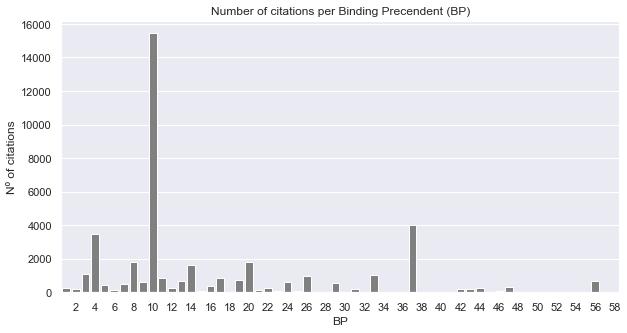

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=list(range(1, 58+1)), y=[len(df) if df is not None else 0 for df in dfs], color='gray', ax=ax)
ax.set_xticklabels([str(i) if i % 2 == 0 else '' for i in range(1, 59)])
plt.title('Number of citations per Binding Precendent (BP)')
plt.xlabel('BP')
plt.ylabel('Nº of citations');

We see that the number of citations per BP is not uniform. BP 10, for example, has the greates number of citations, followed by 37, 4 and 8. This huge difference in number of citations can impact our analysis if we don't work around it.

We already know the documents are long, but one could want to know how long these documents are. If we split each document at whitespaces and newlines and count the number of ``words'', we have an estimative of word count distribution of the documents.

In [8]:
df = pd.concat(dfs, ignore_index=True)
df = df[~df.title.duplicated()].reset_index(drop=True)
df

,title,raw_text,i_cite,date
0,19700101_RE_422410_3279878,DESPACHO: Dê-se vista à PGR para elaboração de...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
1,20081111_RE_581675_2329113,DECISÃO\n\nVistos.\n\nCaixa Econômica Federal ...,['sum. vinc. 1 N/A STF N/A'],2008-11-11
2,19700101_RE_606035_3280058,DESPACHO: Dê-se vista à PGR para elaboração de...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
3,19700101_RE_637135_1424289,DJe 05/09/2011\n\nDecisão sobre Repercussão Ge...,['sum. vinc. 1 N/A STF N/A'],1970-01-01
4,20171122_Rcl_28954_313332094,MEDIDA CAUTELAR NA RECLAMAÇÃO 28.954 DISTRITO ...,['sum. vinc. 1 N/A STF N/A 167 15'],2017-11-22
...,...,...,...,...
38359,20161205_HC_138632_310876555,MEDIDA CAUTELAR NO HABEAS CORPUS 138.632 MINAS...,"['hc 118212 4419627 STF N/A 1728 348', 'hc 668...",2016-12-05
38360,20181031_HC_162238_15338953871,Ementa e AcórdãoDocumento assinado digitalment...,"['hc 108877 3748163 STJ N/A 337 184', 'hc 1360...",2018-10-31
38361,20181015_HC_152642_15338840024,Ementa e AcórdãoDocumento assinado digitalment...,"['sum. 440 N/A STJ N/A 290 72', 'hc 402602 470...",2018-10-15
38362,20180927_HC_162543_15338719562,Documento assinado digitalmente conforme MP n°...,"['aresp 1169 4004318 STJ N/A 4 3', 'hc 108877 ...",2018-09-27


In [9]:
counts = np.array(df.raw_text.apply(lambda x: len(x.split())).to_list())

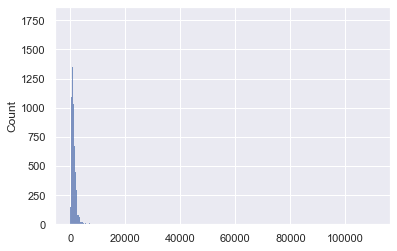

In [10]:
sns.histplot(data=counts);

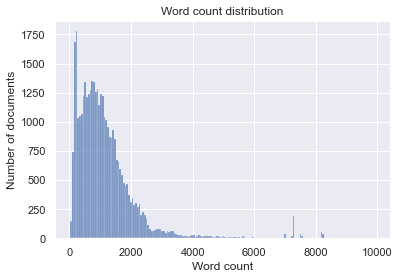

In [11]:
sns.histplot(data=counts[counts < 10000])
plt.title('Word count distribution')
plt.xlabel('Word count')
plt.ylabel('Number of documents');

There are some special documents (more than 10k words), but their analysis is not our focus. In general, documents are shorter than 6k words, with mode around 1k.

Although document titles are the same, many of them share the same raw text.

In [12]:
df.raw_text.duplicated().sum()/len(df)

0.11474298821812115

This ``duplicate'' rate is around 11\%, and can also impact our subsequent analysis. This way, we need to work around these duplicated documents before fitting out models.

Finally, one could want to see the distribution of publication date.

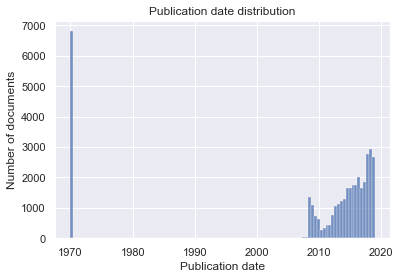

In [13]:
dates = np.array(pd.to_datetime(df.date).to_list())
sns.histplot(data=dates)
plt.title('Publication date distribution')
plt.xlabel('Publication date')
plt.ylabel('Number of documents');

In [14]:
np.min(dates[dates > pd.to_datetime('1970')]), np.max(dates[dates > pd.to_datetime('1970')])

(Timestamp('2003-11-28 00:00:00'), Timestamp('2018-12-19 00:00:00'))

Date distribution has support between 2003 and 2018, but it really concentrates itself between 2008 and 2018. It is clear that many documents have publication year 1970, however this information is acting like a missing value. Although this is problematic, that is, many documents do not have publication date, it will not impact our models, because we will work only with raw texts.

## Methodology

### Dataset split

The main goal of this work is to assert whether traditional machine learning models can ``separate'' documents according to BP citations. We will create two datasets, training and test datasets, that will be used to fit and to test the models, respectively. Some of the models will be fitted in training dataset in a cross validation style, i.e., training data will be splitted in K sets, and, for each set, the model is fitted in all other sets and validated in this set; in the end all metrics are aggregated. This is very usefull in the task of choosing hyperparameters of some models.

- Each document cites one BP
- Remove duplicates
- 4 most cited BPs
- Balanced dataset
- Supervised
    - training set
    - test set
    - cross validation

### Text preprocessing

- lowercase
- tokenize
- lemmatization
- stopwords
- punctuation

### Document embeddings

- TF-IDF
- Doc2vec
<!-- - Universal Sentence Encoder -->
- Dimensionality reduction
    - Truncated SVD
- more vectors?

### Machine learning models

- Linear regression
    - Ridge e LASSO
- Linear Discriminant Analysis
<!-- - QDA -->
- KNN
<!-- - Árvores -->
<!-- - Bagging -->
- Random forest
<!-- - Boosting -->
- Support Vector Machines
- Principal Component Analysis
- K-means
- Hierarchical clustering
<!-- - Gaussian Mixture -->
- Latent Dirichlet Analysis

### Performance metrics

- Accuracy
- Confusion matrix
<!-- - RoC curve -->
<!-- - Cross validation -->
- recall
- precision

## Results and discussion

### Dataset split and text preprocessing

In [15]:
def one_citation(i_cite):
    '''Assert whether the document cite only that BP.'''
    pattern = 'sum. vinc. ([0-9]{1,2})'
    citations = re.findall(pattern, i_cite)
    if len(set(citations)) == 1:
        return True
    return False

In [16]:
sizes = dict()
for bp in range(1, 58+1):
    df = dfs[bp-1]
    if df is not None:
        df = df[df.i_cite.apply(lambda x: one_citation(x))]
        df = df[~df.raw_text.duplicated()]
        df['label'] = bp
        dfs[bp-1] = df
        sizes[bp] = len(df)
    else:
        sizes[bp] = 0

In [17]:
sorted(sizes.items(), key=lambda x: x[1], reverse=True)[:4]

[(10, 13094), (37, 2917), (4, 2540), (20, 1582)]

In [18]:
df_10 = dfs[10-1].sample(1582, random_state=42)
df_37 = dfs[37-1].sample(1582, random_state=42)
df_4 = dfs[4-1].sample(1582, random_state=42)
df_20 = dfs[20-1].sample(1582, random_state=42)

In [19]:
df = pd.concat([df_10, df_37, df_4, df_20], ignore_index=True)
df

,title,raw_text,i_cite,date,label
0,20091014_Rcl_8918_2675717,DECISÃO: 1. Trata-se de reclamação ajuizada pe...,"['sum. vinc. 10 N/A STF N/A', 'rcl 2716 222994...",2009-10-14,10
1,20131119_Rcl_16548_184585137,MEDIDA CAUTELAR NA RECLAMAÇÃO 16.548 RIO GRAND...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 'sum....",2013-11-19,10
2,20110927_ARE_652911_1607711,DJe 06/12/2011\n\nEmenta e Acórdão\n\n27/09/20...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 're 5...",2011-09-27,10
3,20170621_ARE_1052676_312039223,RECURSO EXTRAORDINÁRIO COM AGRAVO 1.052.676 DI...,"['sum. vinc. 10 N/A STF N/A 11937 1187', 'are ...",2017-06-21,10
4,19700101_Rcl_8890_3256407,"DECISÃO: Trata-se de reclamação, ajuizada pelo...","['sum. vinc. 10 N/A STF N/A', 're 240096 17380...",1970-01-01,10
...,...,...,...,...,...
6323,20140203_RE_787075_192761229,RECURSO EXTRAORDINÁRIO 787.075 SANTA CATARINA\...,"['re 476279 2349970 STF N/A 1305 20', 'sum. vi...",2014-02-03,20
6324,20140605_ARE_790259_229696329,RECURSO EXTRAORDINÁRIO COM AGRAVO 790.259 SANT...,"['re 476279 2349970 STF N/A 1305 20', 'ai 7178...",2014-06-05,20
6325,20141030_RE_842822_273608677,RECURSO EXTRAORDINÁRIO 842.822 PARAÍBA\n\nRELA...,"['re 630880 3960331 STF AgR 128 2', 'sum. vinc...",2014-10-30,20
6326,20130920_ARE_676935_171204446,RECURSO EXTRAORDINÁRIO COM AGRAVO 676.935 RIO ...,"['are 751677 4411762 STF N/A 52 0', 'ai 508047...",2013-09-20,20


In [21]:
X = df.raw_text.to_list()
y = df.label.to_list()

In [ ]:
def preprocessing()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    shuffle=True,
    stratify=y
)

## References